# estimating transition marginal (K) from joint (K×K)

In [3]:
using Distributions
using Plots
pyplot()

Plots.PyPlotBackend()

In [4]:
include("src/NGSIM.jl")

chmm_em! (generic function with 1 method)

In [5]:
K = 5
KK = K^2
D = 3
T = 5_000_000
# T = 10_000_000

model = rand_chmm(K, D)
;

In [6]:
(Z, X1, X2) = simulate_model(model, T)
;

In [16]:
P = zeros(K, K, K)

for i in 1:K
    for j in 1:i
        k1 = sub2ind((K, K), i, j)
        k2 = sub2ind((K, K), j, i)
        A = reshape(P_flat[:, k1], K, K) + reshape(P_flat[:, k2], K, K)'
        
        p1, p2 = estimate_outer_double(A)
        P[:, i, j] = p1
        P[:, j, i] = p2
        
#         P_counts[:, i, j] = vec(sum(A, 2)) ./ 2
#         P_counts[:, j, i] = vec(sum(A, 1)) ./ 2
    end
end

## how well does it work on the data?

In [14]:
P_flat = model.P
Phat_flat = zeros(KK, KK)
for i in 1:(T-1)
    w1 = sub2ind((K, K), Z[:, i]...)
    w2 = sub2ind((K, K), Z[:, i+1]...)

    Phat_flat[w1, w2] += 1
end
Phat_flat ./= sum(Phat_flat, 1)

Phat_svd = zeros(K, K, K)
Phat_counts = zeros(K, K, K)        
for i in 1:K
    for j in 1:i
        k1 = sub2ind((K, K), i, j)
        k2 = sub2ind((K, K), j, i)
        A = reshape(Phat_flat[:, k1], K, K) + reshape(Phat_flat[:, k2], K, K)'

        p1, p2 = estimate_outer_double(A)
        Phat_svd[:, i, j] = p1
        Phat_svd[:, j, i] = p2
        
        Phat_counts[:, i, j] = vec(sum(A, 2)) ./ 2
        Phat_counts[:, j, i] = vec(sum(A, 1)) ./ 2
    end
end


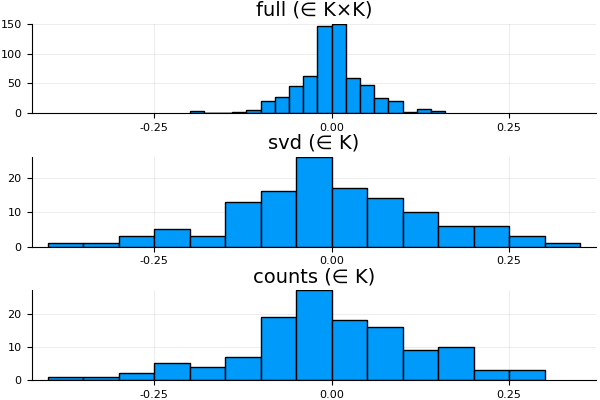

In [17]:
nbins = 30
plot(histogram(vec(Phat_flat.-P_flat), title="full (∈ K×K)", bins=nbins), 
    histogram(vec(Phat_svd.-P), title="svd (∈ K)", bins=nbins), 
    histogram(vec(Phat_counts.-P), title="counts (∈ K)", bins=nbins), 
    layout=(3, 1), link=:x, legend=false)